In [3]:
import os
import sys
from skimage import io, img_as_float, img_as_ubyte
from skimage.transform import rescale, resize
import numpy as np
import matplotlib.pyplot as plt

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.63 ms


In [8]:
def normalize_img_values(img):
    img = img - img.min()
    img = img / img.max()
    img = img_as_ubyte(img)
    return img

time: 736 µs


In [9]:
# FETCH ALL THE IMAGE PATHS

directory = '../Datasets/Bark-101-classified/'
num_imgs = 0
images_paths = []

for filename in os.listdir(directory):
    path = directory + filename
    if not os.path.isdir(path): continue
    #print(path)
    
    # Iterate over every class
    for image_name in os.listdir(path):
        if '.jpg' not in image_name: continue
        #print(image_name)
        num_imgs += 1
        images_paths.append(path+'/'+image_name)
        #print( (path+'/'+image_name).split('/') )
        
images_paths.sort(key=lambda x: int(x.split('/')[-2]) )
        
print('Total number of images:', num_imgs)

Total number of images: 2586
time: 8.92 ms


In [10]:
print(images_paths)

['../Datasets/Bark-101-classified/0/75306.jpg', '../Datasets/Bark-101-classified/0/98033.jpg', '../Datasets/Bark-101-classified/0/14837.jpg', '../Datasets/Bark-101-classified/0/97885.jpg', '../Datasets/Bark-101-classified/0/86356.jpg', '../Datasets/Bark-101-classified/0/10574.jpg', '../Datasets/Bark-101-classified/0/38328.jpg', '../Datasets/Bark-101-classified/0/48224.jpg', '../Datasets/Bark-101-classified/0/79141.jpg', '../Datasets/Bark-101-classified/0/108842.jpg', '../Datasets/Bark-101-classified/0/53891.jpg', '../Datasets/Bark-101-classified/0/74243.jpg', '../Datasets/Bark-101-classified/0/23185.jpg', '../Datasets/Bark-101-classified/0/44037.jpg', '../Datasets/Bark-101-classified/0/54371.jpg', '../Datasets/Bark-101-classified/0/109007.jpg', '../Datasets/Bark-101-classified/0/55129.jpg', '../Datasets/Bark-101-classified/0/64212.jpg', '../Datasets/Bark-101-classified/0/351.jpg', '../Datasets/Bark-101-classified/0/87273.jpg', '../Datasets/Bark-101-classified/0/85849.jpg', '../Datasets

In [12]:
# MOVE ALL THE CLASSIFIED IMAGES TO A UNIQUE FOLDER

dataset_path = '../Datasets/Bark-101-raw/'
if not os.path.exists(dataset_path): os.mkdir(dataset_path)

count = 0
for path in images_paths:
    img = img_as_float(io.imread(path))
    img = normalize_img_values(img)
    #print(img.dtype, img.max(), img.min(), img.shape)
    
    class_num = path.split('/')[-2]
    image_name = str(class_num) + '_' + str(count) + '.jpg'
    #image_name = str(count) + '.jpg'
    io.imsave(dataset_path + image_name, img)
    
    count += 1
    
print(count,'images saved to',dataset_path)

/home/albert.garcia/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


2586 images saved to ../Datasets/Bark-101-raw/
time: 1min 33s


In [13]:
# NORMALIZATION PROCESS (256x256x3 final shape)

def normalize_image(img):
    width_scale = 256/img.shape[1]
    img = rescale(img, width_scale, multichannel=True)
    
    assert img.shape[1] == 256, 'Error in shape after rescaling width'
    
    if img.shape[0] < 256:
        img = resize(img, output_shape=(256,256,3))
        yield normalize_img_values(img)
    else:
        pixels_count = 0
        max_pixels = img.shape[0]
        
        while pixels_count+256 <= max_pixels:
            crop = img[pixels_count : pixels_count+256, :, :]
            pixels_count += 256
            
            assert crop.shape == (256, 256, 3), 'Error in shape of a crop '+str(crop.shape)
            yield normalize_img_values(crop)
      
    
def optimized_normalize_image(img):
    width_images = int(img.shape[1]/256)
    
    if width_images <= 1:
        return normalize_image(img)
    else:
        for section in range(0, 257*width_images, 256):
            vertical_section = img[:, section:section+256, :]
            assert vertical_section.shape[1] == 256, 'Error in width of vertical section '+vertical_section.shape[1]
            return normalize_image(vertical_section)

time: 4.23 ms


(256, 256, 3) uint8 255 0


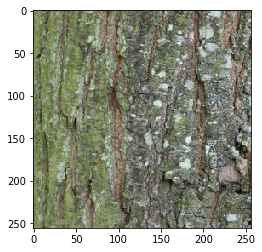

(256, 256, 3) uint8 255 0


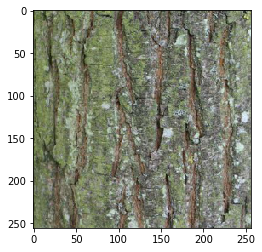

time: 416 ms


In [14]:
# TEST NORMALIZATION PROCESS

source = img_as_float(io.imread(dataset_path+'0_0.jpg'))
for img in normalize_image(source):
    print(img.shape, img.dtype, img.max(), img.min())
    plt.imshow(img)
    plt.show()

In [21]:
# NORMALIZE SIZES OF BARK RAW IMAGES INTO NEW FOLDER

dataset_path = '../Datasets/Bark-101-raw/'
final_dataset_path = '../Datasets/Bark-dataset/'
if not os.path.exists(final_dataset_path): os.mkdir(final_dataset_path)

count = 0
for filename in sorted(os.listdir(dataset_path), key=lambda x: int(x.split('_')[0]) ):
    if '.jpg' not in path: continue
    
    img = img_as_float(io.imread(dataset_path+filename))
    #print(img.shape, img.dtype, img.max(), img.min())

    for normalized_img in normalize_image(img):
        assert normalized_img.shape == (256, 256, 3), 'Error in shape of a normalized image'
        assert normalized_img.dtype == np.uint8, 'Error in dtype of a normalized image'
        assert normalized_img.max() == 255, 'Error in max value of a normalized image'
        assert normalized_img.min() == 0, 'Error in min value of a normalized image'
        
        image_name = filename.split('_')[0] + '_' + str(count) + '.jpg'
        io.imsave(final_dataset_path + image_name, normalized_img)

        count += 1
    
print(count,'normalized images saved to',final_dataset_path)

3729 normalized images saved to ../Datasets/Bark-dataset/
time: 2min


In [22]:
# OPTIMALLY NORMALIZE SIZES OF BARK RAW IMAGES INTO NEW FOLDER

dataset_path = '../Datasets/Bark-101-raw/'
optimized_dataset_path = '../Datasets/Bark-dataset-optimized/'
if not os.path.exists(optimized_dataset_path): os.mkdir(optimized_dataset_path)

count = 0
for filename in sorted(os.listdir(dataset_path), key=lambda x: int(x.split('_')[0])):
    if '.jpg' not in path: continue
    
    img = img_as_float(io.imread(dataset_path+filename))
    #print(img.shape, img.dtype, img.max(), img.min())

    for normalized_img in optimized_normalize_image(img):
        assert normalized_img.shape == (256, 256, 3), 'Error in shape of a normalized image'
        assert normalized_img.dtype == np.uint8, 'Error in dtype of a normalized image'
        assert normalized_img.max() == 255, 'Error in max value of a normalized image'
        assert normalized_img.min() == 0, 'Error in min value of a normalized image'
        
        image_name = filename.split('_')[0] + '_' + str(count) + '.jpg'
        io.imsave(optimized_dataset_path + image_name, normalized_img)

        count += 1
    
print(count,'optimized normalized images saved to',optimized_dataset_path)

4311 optimized normalized images saved to ../Datasets/Bark-dataset-optimized/
time: 1min 57s
